# 配置环境

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
print("Setup Complete")

Setup Complete


# 差分隐私处理

## Step 1 import packages

In [20]:
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

## Step 2 user-defined parameteres

In [21]:
# input dataset
file_name = "adult_processed_train"
input_data = "./data/" + file_name + ".csv"
# location of two output files
mode = 'correlated_attribute_mode'
description_file = f"./out/{mode}/" + file_name + "_synthetic_description.json"
synthetic_data = f"./out/{mode}/" + file_name + "_synthetic_data.csv"

input_data, description_file, synthetic_data

('./data/adult_processed_train.csv',
 './out/correlated_attribute_mode/adult_processed_train_synthetic_description.json',
 './out/correlated_attribute_mode/adult_processed_train_synthetic_data.csv')

In [22]:
input_df = pd.read_csv(input_data)
input_df.head()

,age,educational-num,marital-status,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,employment_type
0,52,13,0,2,0,1,0,0,50,1,0,1
1,67,9,0,1,0,0,0,0,2,1,1,2
2,23,9,0,3,3,1,0,0,60,1,1,1
3,41,13,0,2,0,1,0,0,45,1,0,0
4,58,9,0,2,0,1,0,0,40,0,0,1


In [23]:
input_df.shape

(33916, 12)

In [24]:
# An attribute is categorical if its domain size is less than this threshold.
# Here modify the threshold to adapt to the domain size of "education" (which is 14 in input dataset).
threshold_value = 10

# specify categorical attributes
# categorical_attributes = {'education': True}
categorical_attributes = {'class': True}

# specify which attributes are candidate keys of input dataset.
# candidate_keys = {'ssn': True}
candidate_keys = {}

# A parameter in Differential Privacy. It roughly means that removing a row in the input dataset will not 
# change the probability of getting the same output more than a multiplicative difference of exp(epsilon).
# Increase epsilon value to reduce the injected noises. Set epsilon=0 to turn off differential privacy.
epsilon = 200

# The maximum number of parents in Bayesian network, i.e., the maximum number of incoming edges.
degree_of_bayesian_network = 1

# Number of tuples generated in synthetic dataset.
num_tuples_to_generate = input_df.shape[0] # Here input_df.shape[0] is the same as input dataset, but it can be set to another number.

## Step 3 DataDescriber

1. Instantiate a DataDescriber.
2. Compute the statistics of the dataset.
3. Save dataset description to a file on local machine.

In [25]:
describer = DataDescriber(category_threshold=threshold_value)
describer.describe_dataset_in_correlated_attribute_mode(dataset_file=input_data, 
                                                        epsilon=epsilon, 
                                                        k=degree_of_bayesian_network,
                                                        attribute_to_is_categorical=categorical_attributes,
                                                        attribute_to_is_candidate_key=candidate_keys)
describer.save_dataset_description_to_file(description_file)

================ Constructing Bayesian Network (BN) ================
Adding ROOT capital-gain
Adding attribute income
Adding attribute marital-status


/home/vai/anaconda3/envs/privacy/lib/python3.9/site-packages/DataSynthesizer/lib/PrivBayes.py:192: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute relationship
Adding attribute educational-num
Adding attribute age
Adding attribute gender
Adding attribute hours-per-week
Adding attribute native-country
Adding attribute race
Adding attribute employment_type
Adding attribute capital-loss
========================== BN constructed ==========================


In [26]:
display_bayesian_network(describer.bayesian_network)

Constructed Bayesian network:
    income          has parents ['capital-gain'].
    marital-status  has parents ['income'].
    relationship    has parents ['income'].
    educational-num has parents ['income'].
    age             has parents ['relationship'].
    gender          has parents ['relationship'].
    hours-per-week  has parents ['age'].
    native-country  has parents ['educational-num'].
    race            has parents ['native-country'].
    employment_type has parents ['age'].
    capital-loss    has parents ['income'].


## Step 4 generate synthetic dataset

1. Instantiate a DataGenerator.
2. Generate a synthetic dataset.
3. Save it to local machine.

In [27]:
generator = DataGenerator()
generator.generate_dataset_in_correlated_attribute_mode(num_tuples_to_generate, description_file)
generator.save_synthetic_data(synthetic_data)

## Step 5 compare the statistics of input and sythetic data (optional)

The synthetic data is already saved in a file by step 4. The ModelInspector is for a quick test on the similarity between input and synthetic datasets.

### 5.1 instantiate a ModelInspector.

It needs input dataset, synthetic dataset, and attribute description.

In [28]:
input_df.head()

,age,educational-num,marital-status,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,employment_type
0,52,13,0,2,0,1,0,0,50,1,0,1
1,67,9,0,1,0,0,0,0,2,1,1,2
2,23,9,0,3,3,1,0,0,60,1,1,1
3,41,13,0,2,0,1,0,0,45,1,0,0
4,58,9,0,2,0,1,0,0,40,0,0,1


In [29]:
synthetic_df = pd.read_csv(synthetic_data)
synthetic_df.head()

,age,educational-num,marital-status,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,employment_type
0,42.0,14.0,0,2,0,1,0,0,39.0,1,0,1
1,38.0,9.0,0,1,0,0,0,0,38.0,1,1,1
2,22.0,9.0,1,3,0,1,0,0,29.0,1,1,1
3,29.0,6.0,1,2,0,1,0,0,50.0,1,1,1
4,26.0,9.0,1,2,0,1,0,0,36.0,1,1,1


In [30]:
synthetic_df.columns

Index(['age', 'educational-num', 'marital-status', 'relationship', 'race',
       'gender', 'capital-gain', 'capital-loss', 'hours-per-week',
       'native-country', 'income', 'employment_type'],
      dtype='object')

In [31]:
# Read attribute description from the dataset description file.
attribute_description = read_json_file(description_file)['attribute_description']

inspector = ModelInspector(input_df, synthetic_df, attribute_description)

### 5.2 compare histograms between input and synthetic datasets.

In [32]:
# for attribute in synthetic_df.columns:
#     print(attribute)
#     inspector.compare_histograms(attribute)

### 5.3 compare pairwise mutual information

In [33]:
# inspector.mutual_information_heatmap()

# 可视化的比较

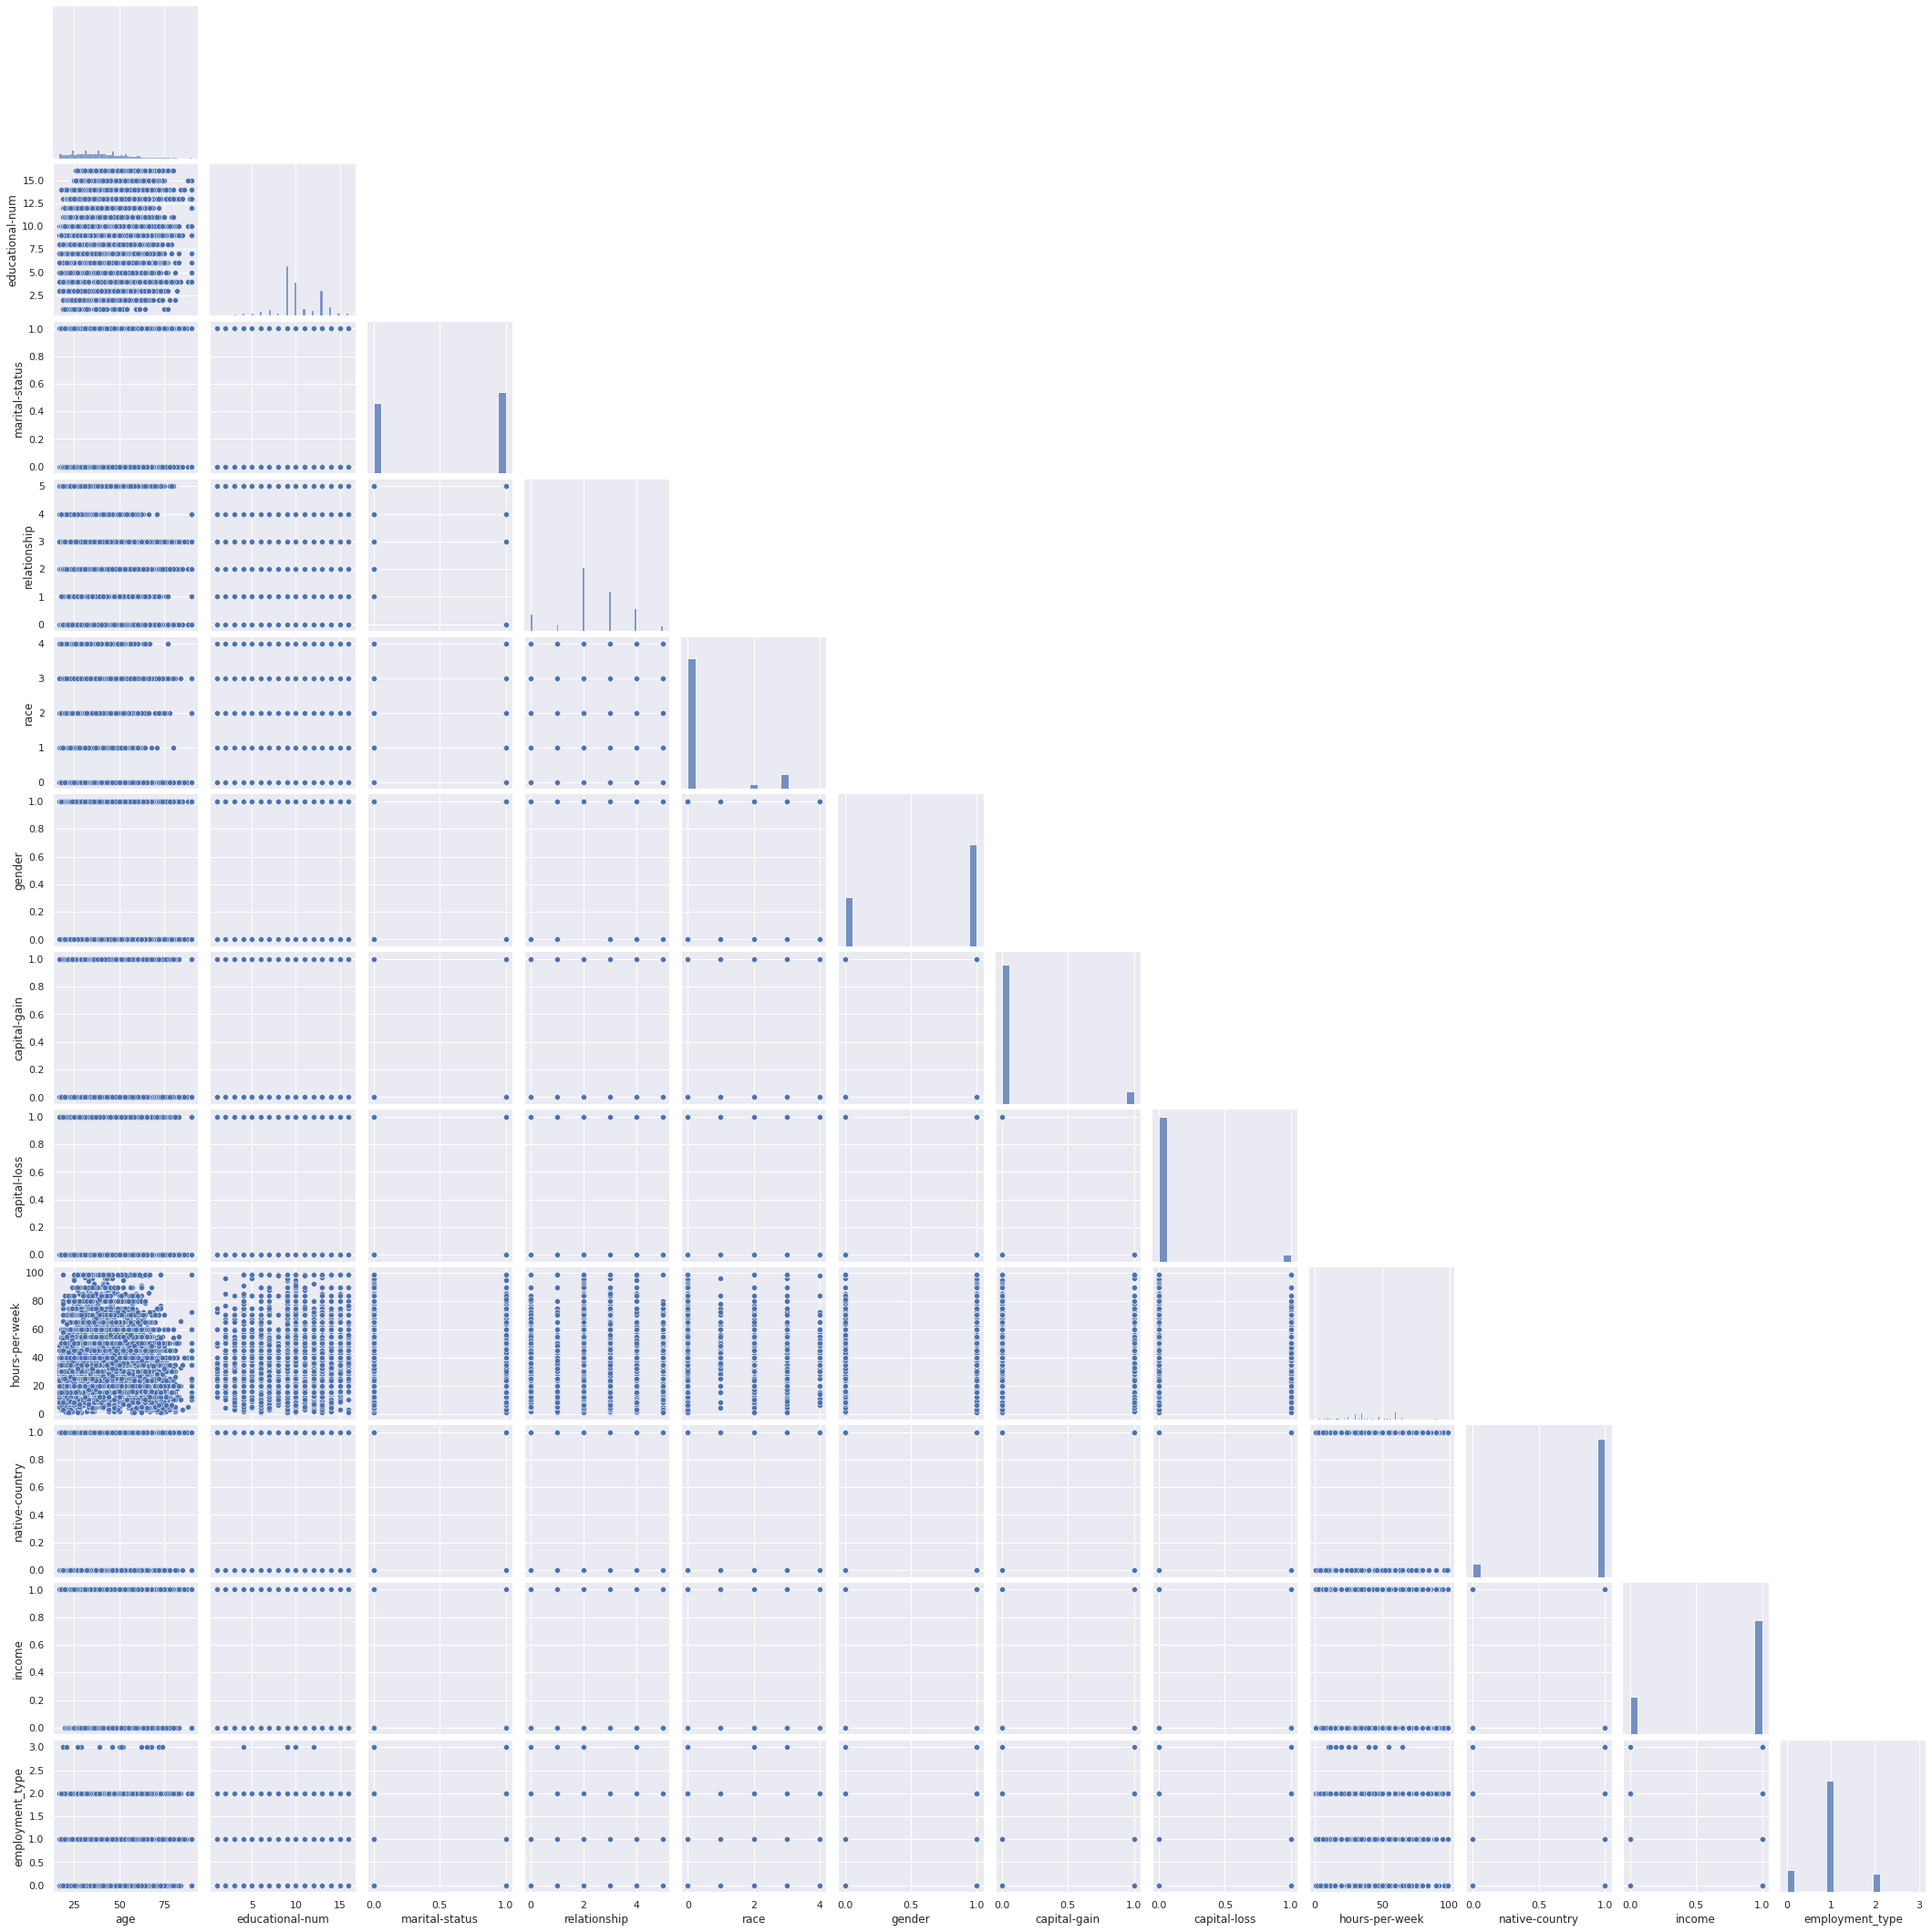

In [34]:
original_sns_plot = sns.pairplot(input_df, corner=True)

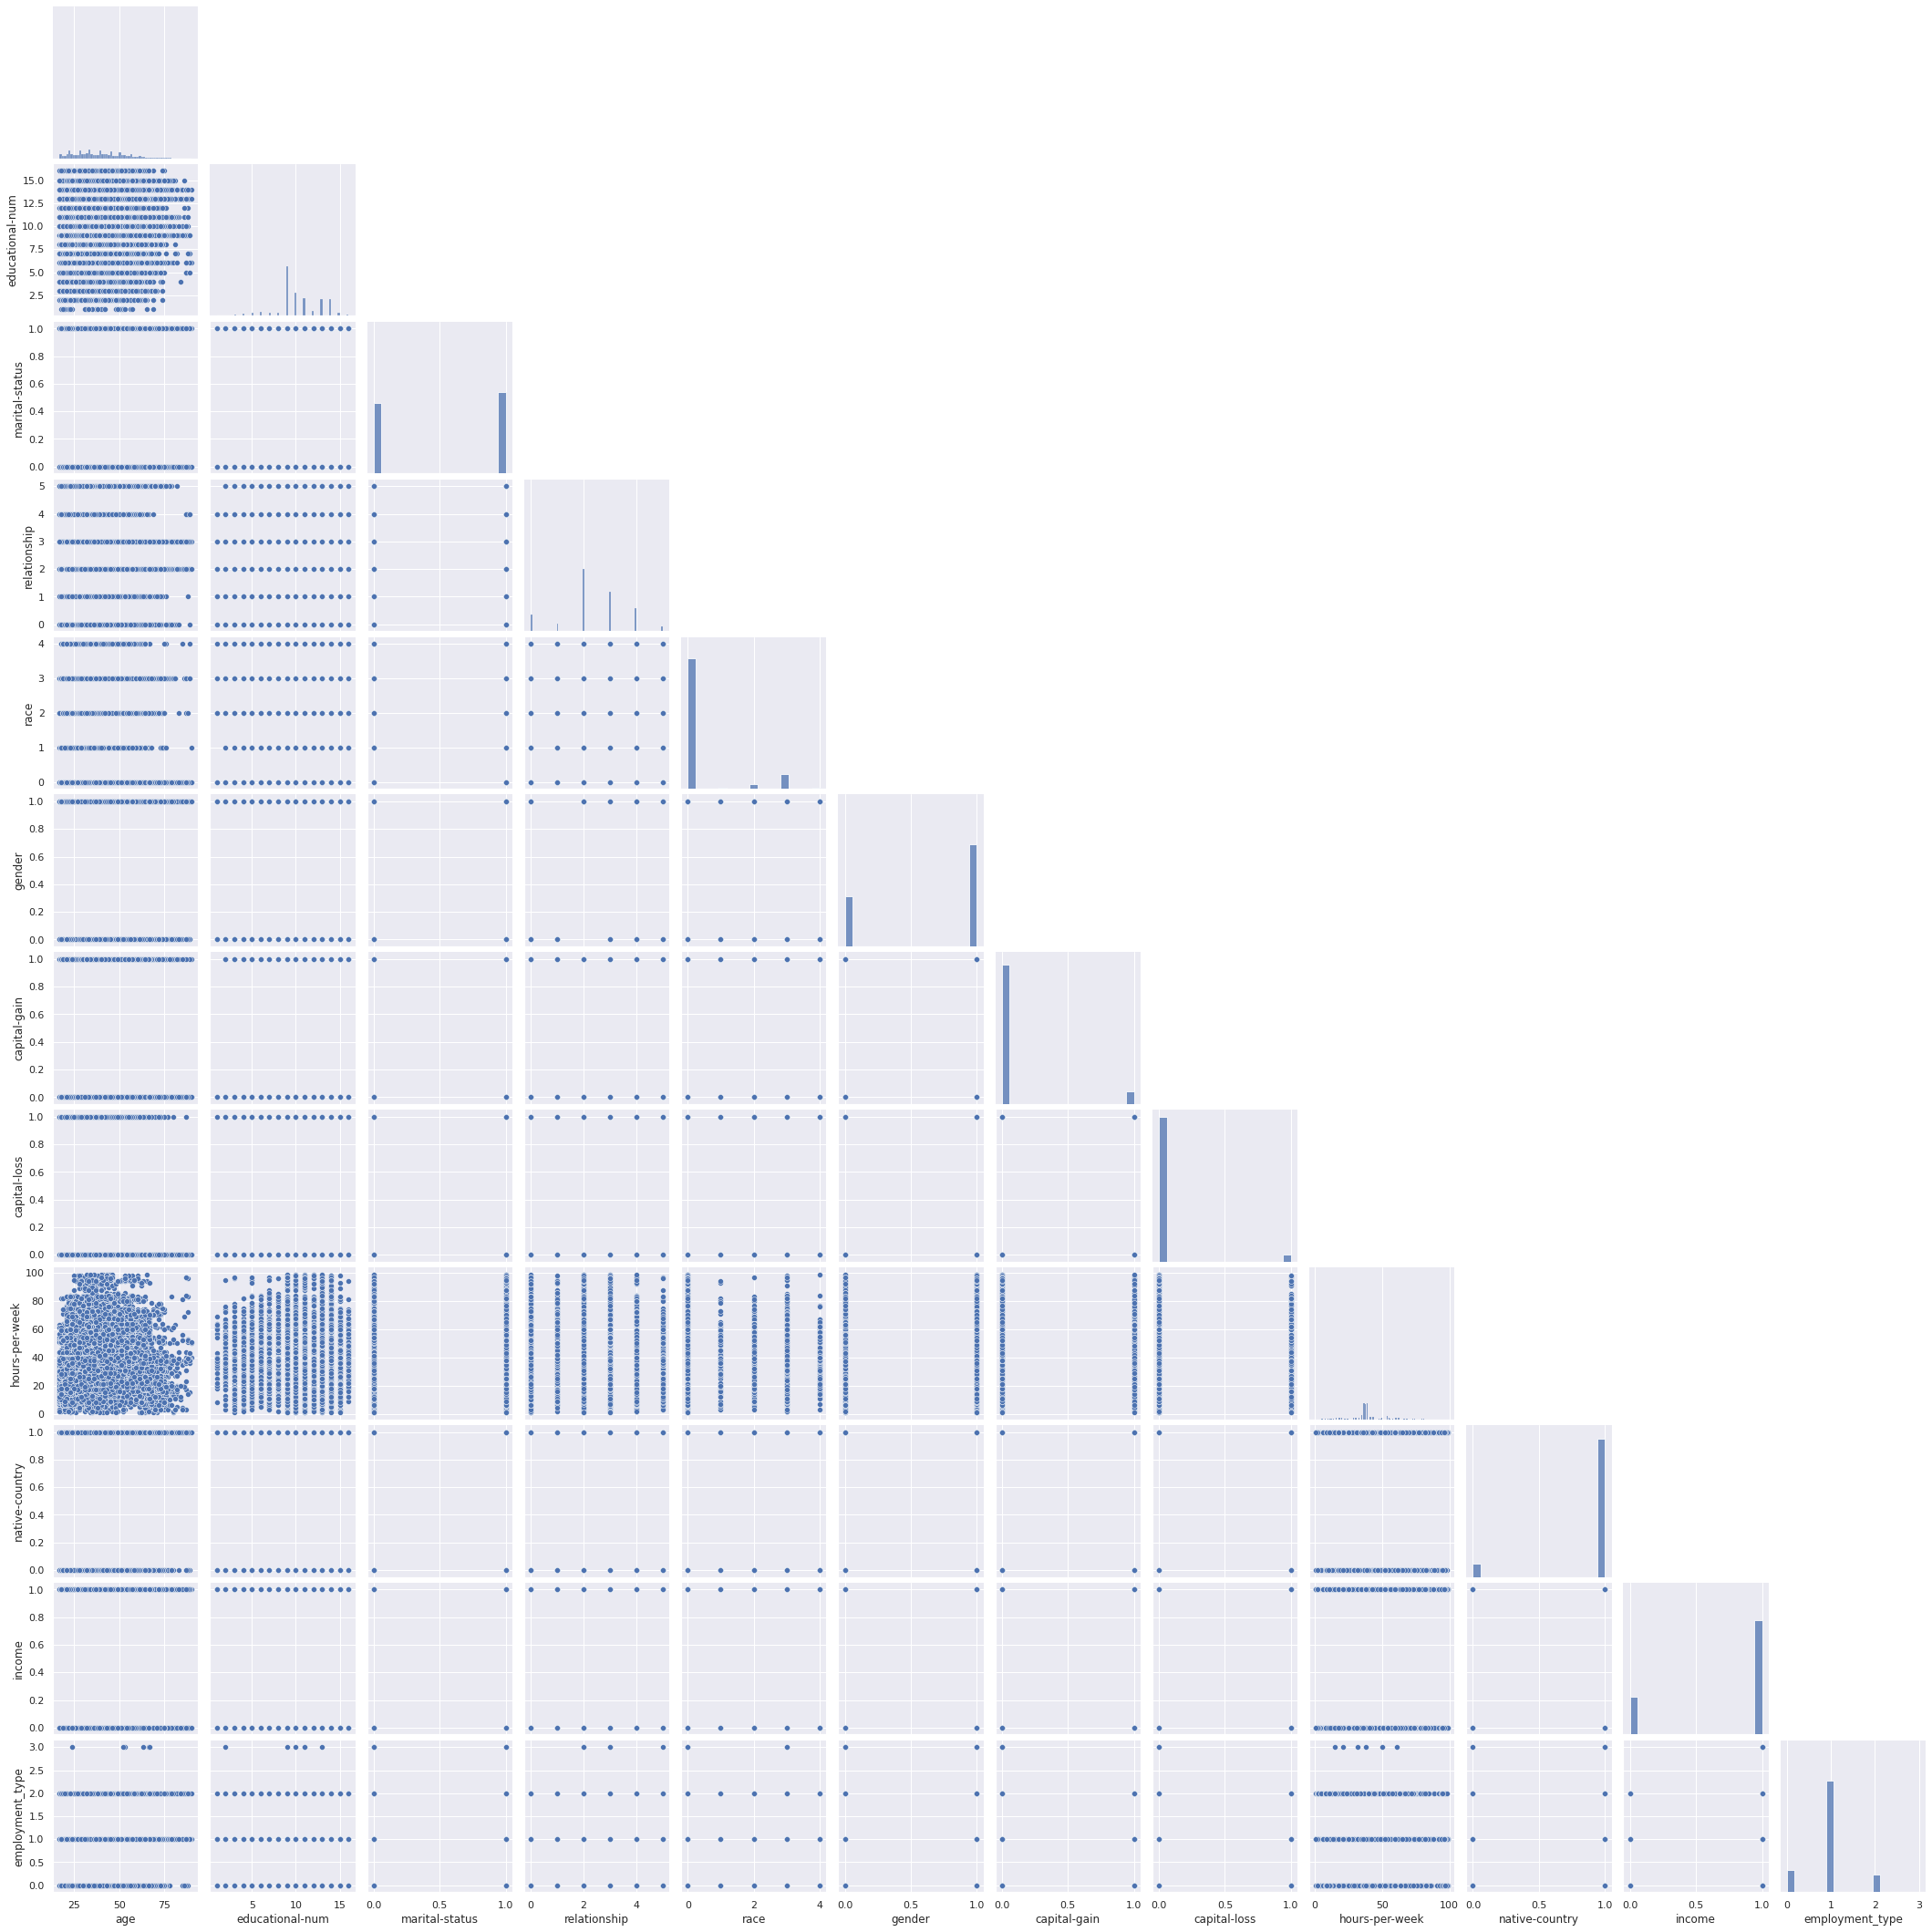

In [35]:
synthetic_sns_plot = sns.pairplot(synthetic_df, corner=True)